# EDA and Cleanup Data

- **Author:** Ashutosh Shirsat  
- **Project:** Data Science/ML 
- **Objective:** Clean Data and perform EDA before feature selection and Model selection.  

In [1]:
# ## 1. Import Libraries
# %pip install --force-reinstall pandas

import numpy as np
import pandas as pd
import warnings
from scipy.stats import skew
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew

warnings.filterwarnings('ignore')  

## 1. Load and clean Data

This project uses thyroid data (originally from the UCI ML Repository).  
We start by loading the data.
Create Binary Outcome Variable.
Standardizes category values (e.g., replacing “M” with “male” and “F” with “Female”, and converting “t”/“f” to Boolean values).

In [2]:
# Load the main data
data_path = 'data/thyroidSourceData.csv'  # Update path as needed
rawThyroidData = pd.read_csv(data_path)

# Identify categorical columns
categorical_cols = rawThyroidData.select_dtypes(include=['object', 'category', 'bool']).columns

# Display the first 5 rows
rawThyroidData.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,target,patient_id
0,29,F,f,f,f,f,f,f,f,t,...,NaN,f,NaN,f,NaN,f,NaN,other,-,840801013
1,29,F,f,f,f,f,f,f,f,f,...,128.0,f,NaN,f,NaN,f,NaN,other,-,840801014
2,41,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,11.0,other,-,840801042
3,36,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,26.0,other,-,840803046
4,32,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,36.0,other,S,840803047


In [3]:

# Update 'sex' column: 'M' -> 'male', 'F' -> 'Female'
rawThyroidData['sex'] = rawThyroidData['sex'].replace({'M': 'male', 'F': 'Female'})

# List of columns to update (exclude 'thyroid' and 'referral_source')
cols_to_update = [col for col in categorical_cols if col not in ['referral_source', 'sex']]

# Replace 't'/'f' with True/False in the selected columns
rawThyroidData[cols_to_update] = rawThyroidData[cols_to_update].replace({'t': True, 'f': False})

# Display the first few rows to verify changes
rawThyroidData.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,target,patient_id
0,29,Female,False,False,False,False,False,False,False,True,...,NaN,False,NaN,False,NaN,False,NaN,other,-,840801013
1,29,Female,False,False,False,False,False,False,False,False,...,128.0,False,NaN,False,NaN,False,NaN,other,-,840801014
2,41,Female,False,False,False,False,False,False,False,False,...,NaN,False,NaN,False,NaN,True,11.0,other,-,840801042
3,36,Female,False,False,False,False,False,False,False,False,...,NaN,False,NaN,False,NaN,True,26.0,other,-,840803046
4,32,Female,False,False,False,False,False,False,False,False,...,NaN,False,NaN,False,NaN,True,36.0,other,S,840803047


### Create Binary Outcome Variable

The original 'target' variable has 32 classes.
We create a new binary variable `thyroid`:  
- A value of TRUE indicates the presence of the disease if 'target' had a disease code from 'A' to 'H'; 
- otherwise, the value is FALSE, indicating the absence of the disease. 

In [4]:
# Create new Outcome variable 'thyroid' (1 if target in disease_code else 0)
disease_code = ["A", "B", "C", "D", "E", "F", "G", "H"]
rawThyroidData['thyroid'] = rawThyroidData['target'].apply(lambda x: 'True' if x in disease_code else 'False')
# Optionally, move 'thyroid' column to the front
cols = ['thyroid'] + [col for col in rawThyroidData.columns if col != 'thyroid']
rawThyroidData = rawThyroidData[cols]

# Check counts
rawThyroidData['thyroid'].value_counts()

thyroid
False    8397
True      775
Name: count, dtype: int64

### Save the Raw Data

Save the pre-processed data for further steps.
- As CSV (portable)
- As pickle (fast Python loading, optional)

In [5]:
# Save as CSV
rawThyroidData.to_csv('data/rawThyroidData.csv', index=False)

# Save as pickle (optional)
rawThyroidData.to_pickle('data/rawThyroidData.pkl')

## 2. Missing Values

Missing Value General Approach is exclude observation with missing values. 
When paremtere has more more tha 90% missing values, parameter is drop from dataset.
As predictor ‘TBG’ has too many missing values i.e. 96%. Predictor ‘TBG’ is removed. 
Predictor ‘TBG_measured’ is also removed along with ‘TBG’ as this is a flag for measurement of TBG as per data context and interpretation.

In [6]:
# Get missing value statistics
missing_counts = rawThyroidData.isnull().sum()
missing_percent = 100 * missing_counts / len(rawThyroidData)

# Combine into a summary DataFrame
missing_summary = pd.DataFrame({
    'missing_count': missing_counts,
    'missing_percent': missing_percent
})

print("Missing Value Summary per Parameter:")
print(missing_summary[missing_summary['missing_count'] > 0])

Missing Value Summary per Parameter:
     missing_count  missing_percent
sex            307         3.347143
TSH            842         9.180113
T3            2604        28.390754
TT4            442         4.819014
T4U            809         8.820323
FTI            802         8.744003
TBG           8823        96.194941


In [7]:
# Drop columns TBG and TBG_measured.
columns_to_drop = ['TBG', 'TBG_measured']
# Drop the specified columns
cleanThyroidData = rawThyroidData.drop(columns=columns_to_drop)

# Drop rows with missing values in remaining columns
cleanThyroidData = cleanThyroidData.dropna()
print(f"Final dataset shape: {cleanThyroidData.shape}\nRaw dataset shape: {rawThyroidData.shape}")

# Update categorical_cols after dropping columns
categorical_cols = [col for col in categorical_cols if col in cleanThyroidData.columns]
print("Updated categorical columns:", categorical_cols)

Final dataset shape: (5789, 30)
Raw dataset shape: (9172, 32)
Updated categorical columns: ['sex', 'on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_meds', 'sick', 'pregnant', 'thyroid_surgery', 'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium', 'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH_measured', 'T3_measured', 'TT4_measured', 'T4U_measured', 'FTI_measured', 'referral_source', 'target']


## 3. Drop Non informative features.
    Drop non informative columns i.e. 'patient_id' and orginal outcome variable 'target'.

In [8]:
# Drop non informative columns i.e. 'patient_id' and orginal outcome variable 'target'.
columns_noinfomative = ['patient_id', 'target', 'TSH_measured', 'TT4_measured', 'T3_measured', 'FTI_measured']
cleanThyroidData = cleanThyroidData.drop(columns=columns_noinfomative)

# Update categorical_cols after dropping columns
categorical_cols = [col for col in categorical_cols if col in cleanThyroidData.columns]
print("Updated categorical columns:", categorical_cols)

Updated categorical columns: ['sex', 'on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_meds', 'sick', 'pregnant', 'thyroid_surgery', 'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium', 'goitre', 'tumor', 'hypopituitary', 'psych', 'T4U_measured', 'referral_source']


In [9]:
cleanThyroidData.head()
cleanThyroidData.columns


Index(['thyroid', 'age', 'sex', 'on_thyroxine', 'query_on_thyroxine',
       'on_antithyroid_meds', 'sick', 'pregnant', 'thyroid_surgery',
       'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium',
       'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH', 'T3', 'TT4',
       'T4U_measured', 'T4U', 'FTI', 'referral_source'],
      dtype='object')

## 4. Outliers and Non-Normal Distributions

- Removing outliers for age : implausible values are removed. i.e. age > 110.
- Log-transforming skewed variables :
    After evaluating skewness of these variables, skew or Non-Normal distributed variables TSH, T3, T4U will be log-transformed. Skewness of FTI is increased after log transform. 
    TT4 skewness factor is near 1.0. This is the reason FTI and TT4 are not log transformed.
- Producing summary statistics before/after
- Visualizing distributions

In [10]:

# Summary statistics before transformation
print("Summary statistics before log-transform:")
print(cleanThyroidData[['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']].describe())
print('\nSkewness before log-transform:')
for col in ['TSH', 'T3', 'TT4', 'T4U', 'FTI']:
    print(f"{col}: {skew(cleanThyroidData[col].dropna()):.2f}")


Summary statistics before log-transform:
                age          TSH           T3          TT4          T4U  \
count   5789.000000  5789.000000  5789.000000  5789.000000  5789.000000   
mean      76.291242     5.162651     1.948817   107.878089     0.976116   
std     1216.726999    24.530112     0.872959    37.439111     0.193934   
min        1.000000     0.005000     0.050000     2.000000     0.170000   
25%       38.000000     0.400000     1.500000    87.000000     0.860000   
50%       56.000000     1.300000     1.900000   104.000000     0.960000   
75%       69.000000     2.600000     2.300000   125.000000     1.070000   
max    65512.000000   530.000000    18.000000   450.000000     2.330000   

               FTI  
count  5789.000000  
mean    112.130669  
std      37.456203  
min       1.400000  
25%      93.000000  
50%     109.000000  
75%     127.000000  
max     642.000000  

Skewness before log-transform:
TSH: 12.82
T3: 3.06
TT4: 1.27
T4U: 1.11
FTI: 1.92


In [11]:
cleanThyroidData.head()

,thyroid,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,...,tumor,hypopituitary,psych,TSH,T3,TT4,T4U_measured,T4U,FTI,referral_source
19,False,36,Female,False,False,False,False,False,False,False,...,False,False,False,1.50,2.4,90.0,True,1.06,85.0,other
21,False,40,Female,False,False,False,False,False,False,False,...,False,False,False,1.20,2.3,104.0,True,1.08,96.0,other
22,False,40,Female,False,False,False,False,False,False,False,...,False,False,False,5.90,2.1,88.0,True,0.84,105.0,other
23,False,77,Female,False,False,False,False,False,False,False,...,False,False,False,0.05,2.4,107.0,True,1.13,95.0,other
27,False,51,Female,False,False,False,False,False,False,False,...,False,False,False,0.05,2.1,93.0,True,0.87,106.0,SVI


In [12]:
# 1. Remove implausible ages (e.g., age > 110)

cleanThyroidData = cleanThyroidData[cleanThyroidData['age'] < 110]

print(cleanThyroidData.columns)

# 2. Specify variables to log-transform due to skew/outliers
log_vars = ['TSH', 'T3', 'T4U']

# 4. Log-transform (add small constant to avoid log(0))
cleanThyroidData[log_vars] = cleanThyroidData[log_vars].apply(lambda x: np.log(x + 6.5))

# 5. Summary statistics after transformation
print("\nSummary statistics after log-transform:")
print(cleanThyroidData[['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']].describe())
print('\nSkewness after log-transform:')
for col in ['TSH', 'T3', 'TT4', 'T4U', 'FTI']:
    print(f"{col}: {skew(cleanThyroidData[col].dropna()):.2f}")

Index(['thyroid', 'age', 'sex', 'on_thyroxine', 'query_on_thyroxine',
       'on_antithyroid_meds', 'sick', 'pregnant', 'thyroid_surgery',
       'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium',
       'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH', 'T3', 'TT4',
       'T4U_measured', 'T4U', 'FTI', 'referral_source'],
      dtype='object')

Summary statistics after log-transform:
               age          TSH           T3          TT4          T4U  \
count  5786.000000  5786.000000  5786.000000  5786.000000  5786.000000   
mean     53.607328     2.183537     2.129272   107.874742     2.011380   
std      18.795951     0.487536     0.095195    37.448481     0.025616   
min       1.000000     1.872571     1.879465     2.000000     1.897620   
25%      38.000000     1.931521     2.079442    87.000000     1.996060   
50%      56.000000     2.054124     2.128232   104.000000     2.009555   
75%      69.000000     2.208274     2.174752   125.000000     2.024193  

In [13]:
cleanThyroidData.head()

,thyroid,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,...,tumor,hypopituitary,psych,TSH,T3,TT4,T4U_measured,T4U,FTI,referral_source
19,False,36,Female,False,False,False,False,False,False,False,...,False,False,False,2.079442,2.186051,90.0,True,2.022871,85.0,other
21,False,40,Female,False,False,False,False,False,False,False,...,False,False,False,2.041220,2.174752,104.0,True,2.025513,96.0,other
22,False,40,Female,False,False,False,False,False,False,False,...,False,False,False,2.517696,2.151762,88.0,True,1.993339,105.0,other
23,False,77,Female,False,False,False,False,False,False,False,...,False,False,False,1.879465,2.186051,107.0,True,2.032088,95.0,other
27,False,51,Female,False,False,False,False,False,False,False,...,False,False,False,1.879465,2.151762,93.0,True,1.997418,106.0,SVI


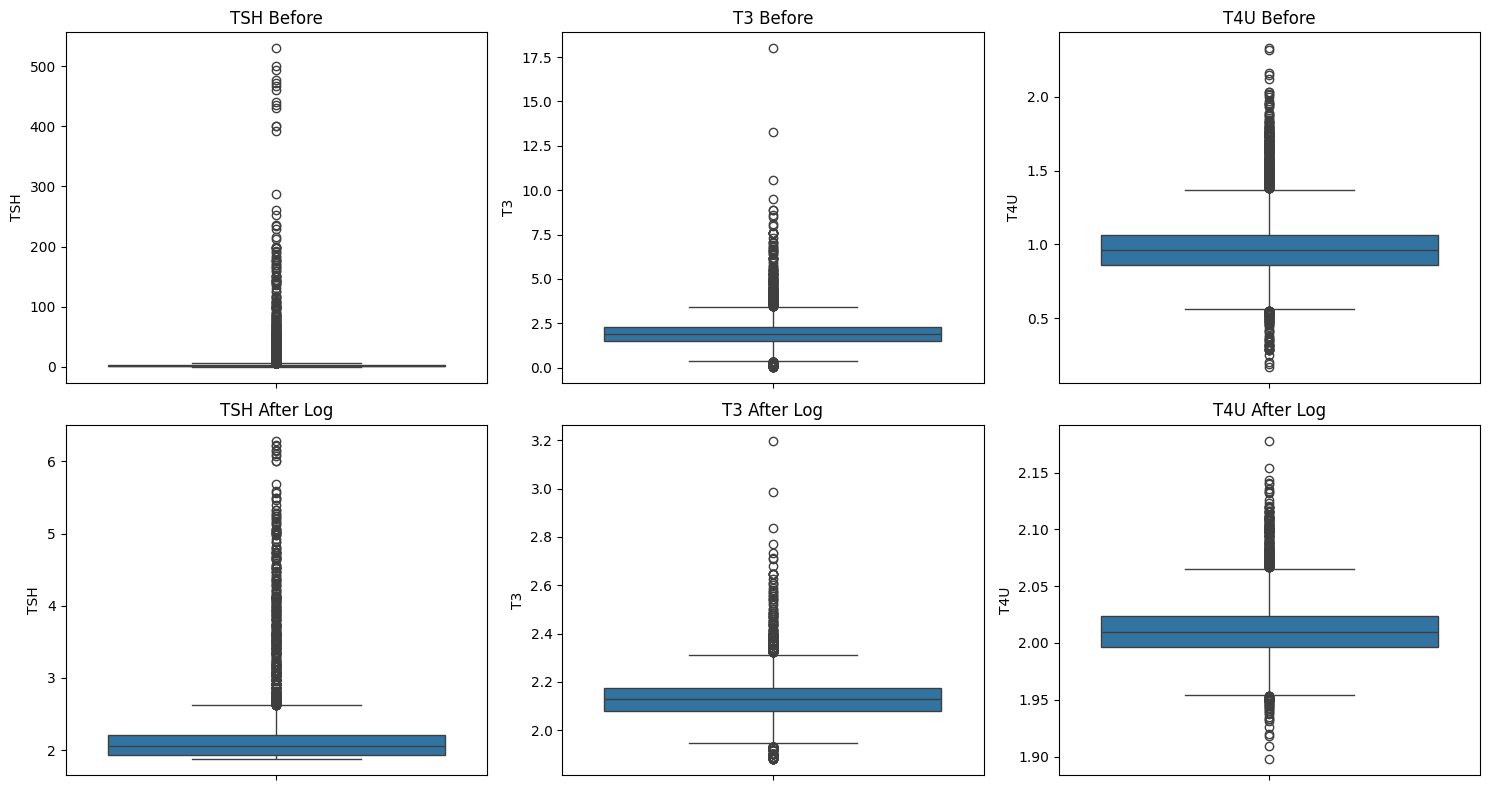

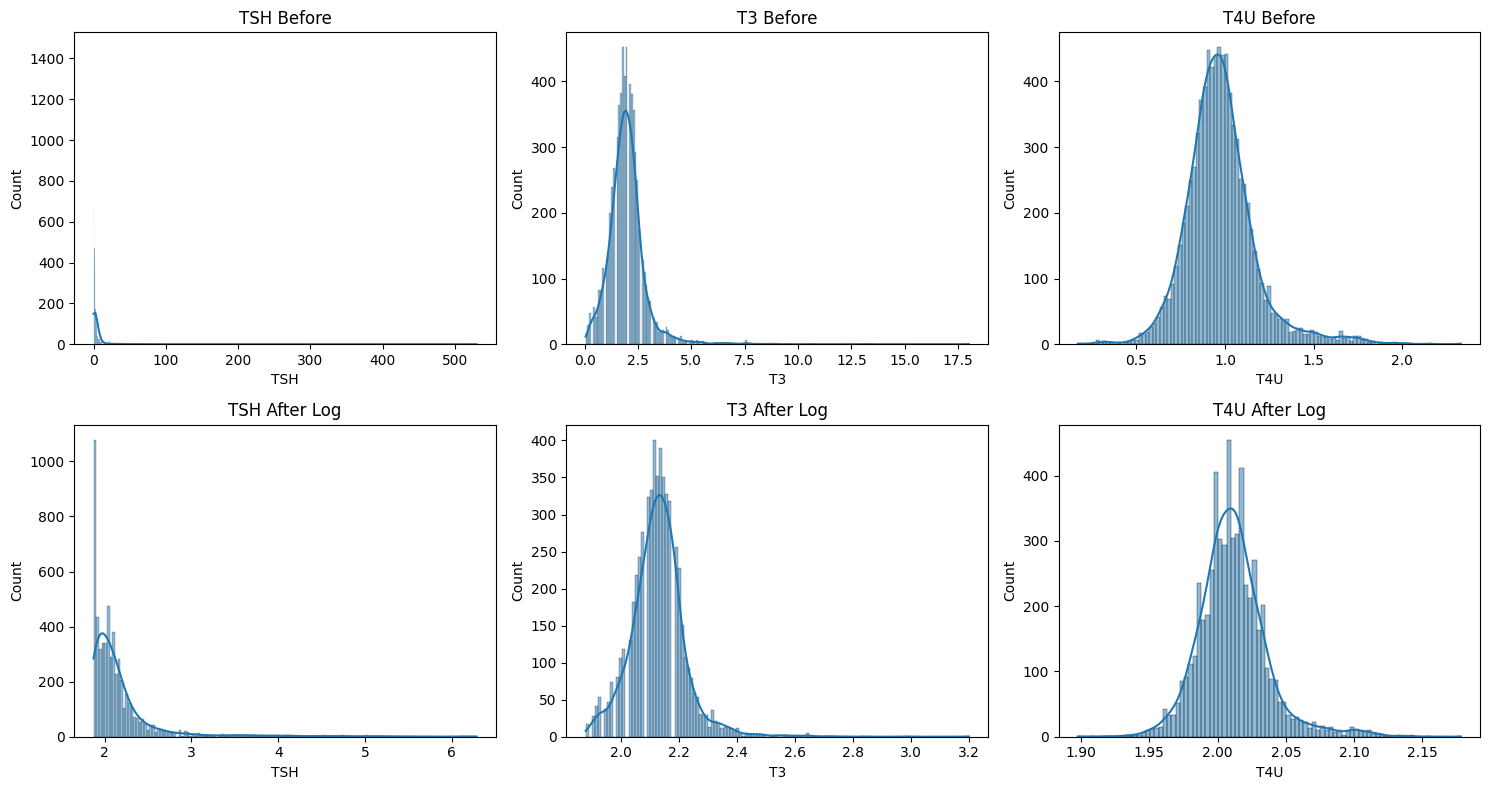

In [14]:

# 6. Visualizations: Boxplots and Histograms before/after
fig, axes = plt.subplots(2, len(log_vars), figsize=(15, 8))
for i, var in enumerate(log_vars):
    # Boxplot before
    sns.boxplot(y=rawThyroidData[var], ax=axes[0, i])
    axes[0, i].set_title(f'{var} Before')
    # Boxplot after
    sns.boxplot(y=cleanThyroidData[var], ax=axes[1, i])
    axes[1, i].set_title(f'{var} After Log')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, len(log_vars), figsize=(15, 8))
for i, var in enumerate(log_vars):
    # Histogram before
    sns.histplot(rawThyroidData[var], kde=True, ax=axes[0, i])
    axes[0, i].set_title(f'{var} Before')
    # Histogram after
    sns.histplot(cleanThyroidData[var], kde=True, ax=axes[1, i])
    axes[1, i].set_title(f'{var} After Log')
plt.tight_layout()
plt.show()

In [15]:
# Save as CSV
cleanThyroidData.to_csv('data/cleanThyroidData.csv', index=False)

# Save as pickle (optional)
cleanThyroidData.to_pickle('data/cleanThyroidData.pkl')

## 5 Exploratory Data Analysis


- **Correlation Matrix:**  
  -  **Strong Correlation:**  
      - **TT4 and FTI** have a strong positive correlation of 0.81.
  - **Moderate Correlations:**  
      - **TSH and FTI** exhibit a moderate negative correlation of -0.45.  
      - **T3 and TT4** show a moderate positive correlation of 0.55.


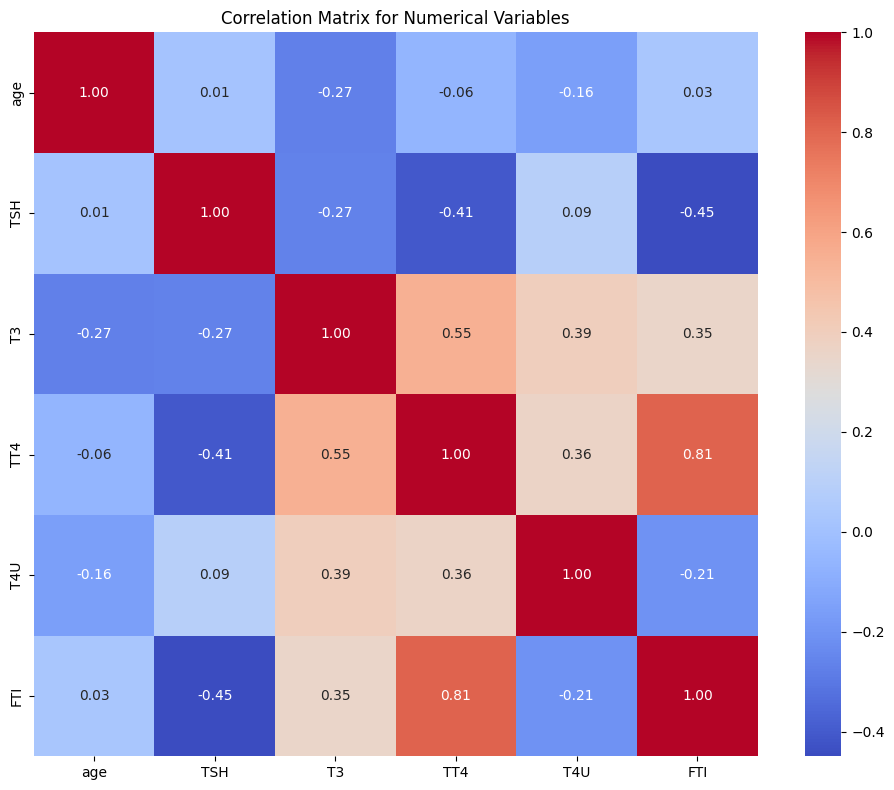

In [16]:
def plot_correlation_matrix(df):
    # Select only numerical columns
    numeric_vars = df.select_dtypes(include=[np.number])
    # Compute correlation matrix
    corr_matrix = numeric_vars.corr()
    # Plot correlation matrix with values
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
    plt.title('Correlation Matrix for Numerical Variables')
    plt.tight_layout()
    plt.show()

plot_correlation_matrix(cleanThyroidData)

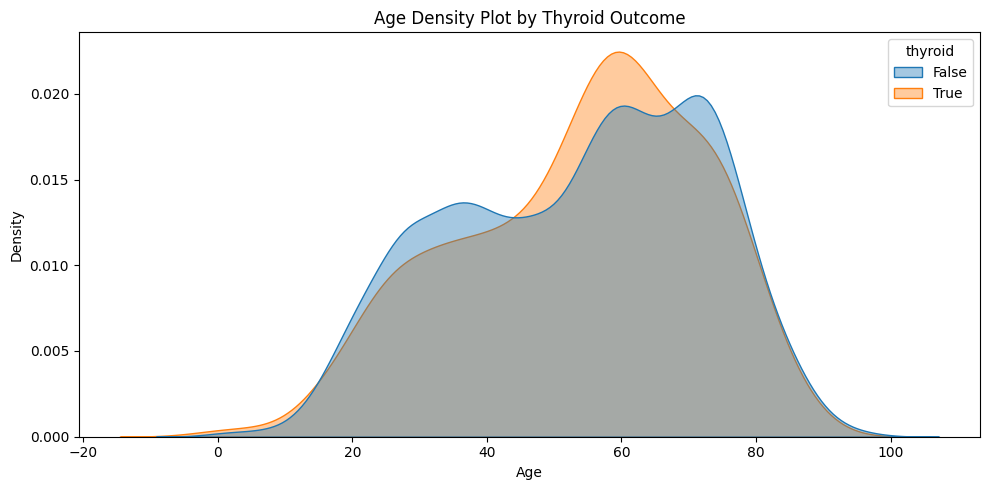

In [17]:
# Age density plot 
plt.figure(figsize=(10, 5))
sns.kdeplot(data=cleanThyroidData, x='age', hue='thyroid', common_norm=False, fill=True, alpha=0.4)
plt.title('Age Density Plot by Thyroid Outcome')
plt.xlabel('Age')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

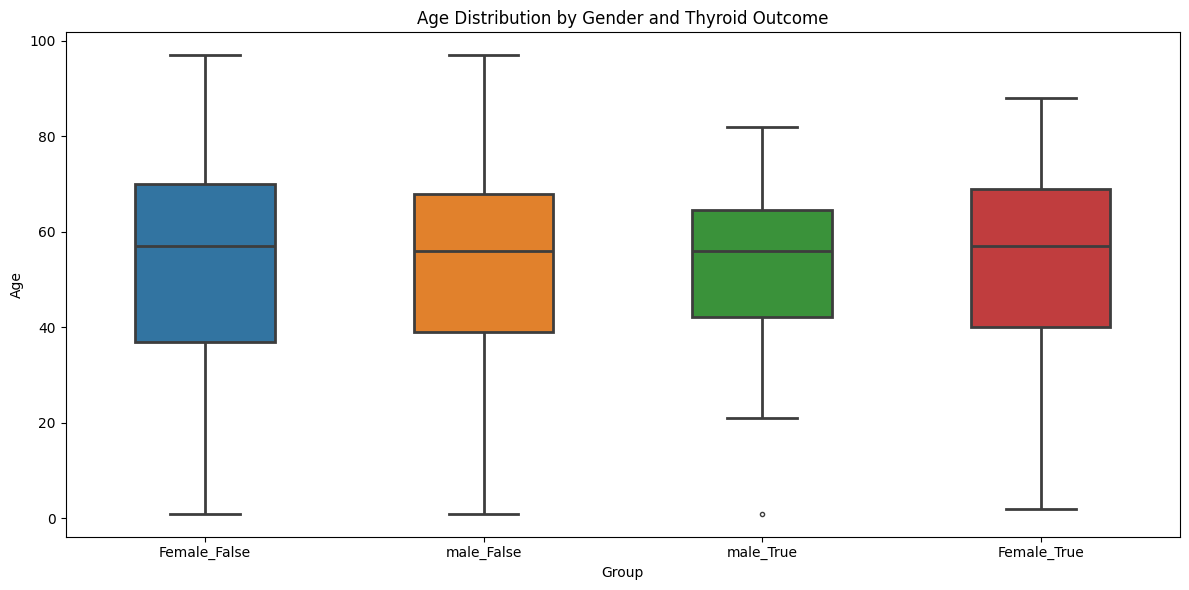

In [18]:
# Suppose cleanThyroidData has columns 'sex', 'thyroid', and 'age'
# Create a combined group column:
temp = cleanThyroidData[['sex', 'thyroid', 'age']].copy()
temp['group'] = temp['sex'] + '_' + temp['thyroid']

plt.figure(figsize=(12, 6))
ax = sns.boxplot(
    data=temp,
    x='group',
    y='age',
   # order=order,
    palette='tab10',
    width=0.5,
    linewidth=2,
    fliersize=3
)
plt.title('Age Distribution by Gender and Thyroid Outcome')
plt.xlabel('Group')
plt.ylabel('Age')
plt.tight_layout()
plt.show()